**Necessary Libraries Installed**

In [ ]:
!sudo apt-get install tesseract-ocr
!pip install easyocr
!pip install opencv-python
!pip install pytesseract
!pip install pandas
!pip install rembg
# !pip install onnxruntime

**Necessary libraries imported**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr
import pandas as pd
from rembg import remove

****This cell removes the background from the OMR sheet image:****

**1. Loads the input image: Reads the OMR sheet image from the specified file path.**

**2. Removes the background: Uses the rembg library to remove the background.**

**3. Saves the result: Saves the background-removed image as 'output.png'.**

**4. Displays the image: Shows the background-removed OMR sheet using matplotlib.pyplot.**

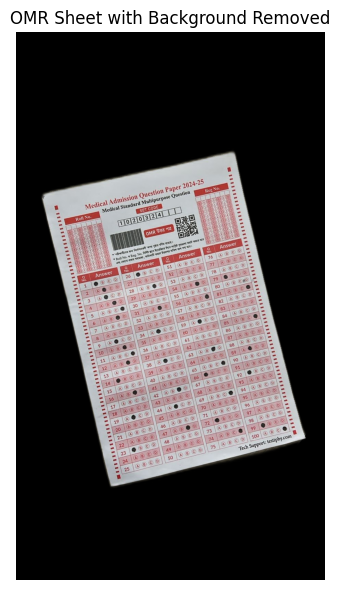

In [26]:
# Step 1: Load the image
image_path = 'unnamed (2).jpg'  # Replace with the actual file path
with open(image_path, 'rb') as i:
    input_image = i.read()

# Step 2: Remove the background
output_image = remove(input_image)

# Step 3: Save the background-removed image
with open('output.png', 'wb') as o:
    o.write(output_image)

# Step 4: Load the background-removed image
image = cv2.imread('output.png')

# Display the OMR sheet with the background removed
plt.figure(figsize=(10, 6))
plt.title("OMR Sheet with Background Removed")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.tight_layout()
plt.show()



# Step-by-Step Process for Processing an OMR Sheet Image

## 1. Load the Background-Removed Image

## 2. Convert to Grayscale

## 3. Apply Gaussian Blur

## 4. Apply Adaptive Thresholding

## 5. Detect Edges Using Canny Edge Detection

## 6. Find Contours

## 7. Identify the Largest Contour (OMR Sheet)
- Iterates through contours and calculates their area using `cv2.contourArea()`.
- Stores the contour with the largest area as `largest_contour`.

## 8. Perform Perspective Transformation
- If a valid `largest_contour` is found (with 4 corners):
  - Calculate the perspective transformation matrix using `cv2.getPerspectiveTransform()`.
  - Apply the transformation using `cv2.warpPerspective()` to align the OMR sheet.

## 9. Display the Aligned Image



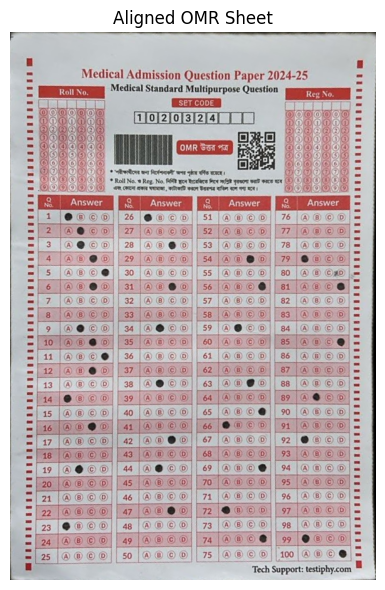

In [27]:
# Step 1: Load the background-removed image
image_path = 'output.png'  # The background-removed image
image = cv2.imread(image_path)

# Step 2: Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 3: Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

# Step 4: Apply Adaptive Thresholding to highlight regions
thresholded = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
)

# Step 5: Detect edges using Canny edge detection with adjusted parameters
edges = cv2.Canny(thresholded, 50, 150)

# Step 6: Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 7: Find the largest contour based on bounding rectangle area
max_area = 0
largest_contour = None

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    area = w * h
    if area > max_area:
        max_area = area
        largest_contour = contour

# Step 8: Transform the perspective of the detected contour if it has 4 corners
if largest_contour is not None:
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
    if len(approx) == 4:
        # Order points in a consistent order
        points = approx.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")
        s = points.sum(axis=1)
        rect[0] = points[np.argmin(s)]
        rect[2] = points[np.argmax(s)]
        diff = np.diff(points, axis=1)
        rect[1] = points[np.argmin(diff)]
        rect[3] = points[np.argmax(diff)]

        # Compute the width and height of the new image
        (tl, tr, br, bl) = rect
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))

        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))

        # Define the destination points for the perspective transform
        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]
        ], dtype="float32")

        # Compute the perspective transform matrix
        M = cv2.getPerspectiveTransform(rect, dst)

        # Perform the perspective transformation
        warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    else:
        warped = image.copy()
else:
    warped = image.copy()

# Plot the warped (aligned) image of the detected contour
plt.figure(figsize=(10, 6))

plt.title("Aligned OMR Sheet")
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()



# Step-by-Step Process for Detecting Answer Sheet Regions

## 1. Load the Aligned OMR Sheet Image


## 2. Convert to Grayscale


## 3. Apply Gaussian Blur to Reduce Noise


## 4. Apply Adaptive Thresholding to Highlight Regions


## 5. Detect Contours in the Thresholded Image


## 6. Filter Contours to Find Answer Sheet Regions


## 7. Sort Contours Left-to-Right and Top-to-Bottom


## 8. Draw Detected Answer Sheet Contours


## 9. Display the Result with Detected Answer Sheet Contours


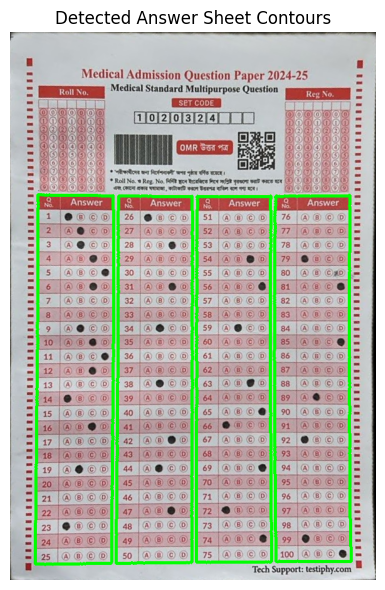

In [28]:
# Load the aligned OMR sheet image
aligned_image = warped  # The output from the previous alignment step

# Convert to grayscale
gray = cv2.cvtColor(aligned_image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (1, 3), 0)

# Apply Adaptive Thresholding to highlight regions
thresholded = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
)

# Detect contours in the thresholded image
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours to find the answer sheet regions (based on contour area or shape)
answer_sheet_contours = []
for contour in contours:
    area = cv2.contourArea(contour)
    if 50000 < area < 1000000:  # Adjust the range based on actual sizes of answer sheet parts
        answer_sheet_contours.append(contour)

# Sort contours left-to-right and top-to-bottom
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    bounding_boxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, bounding_boxes) = zip(*sorted(zip(cnts, bounding_boxes),
        key=lambda b: b[1][i], reverse=reverse))
    return cnts, bounding_boxes

sorted_answer_sheets, _ = sort_contours(answer_sheet_contours, method="top-to-bottom")

# Draw the detected answer sheet contours on the image
result_image = aligned_image.copy()
for contour in sorted_answer_sheets:
    cv2.drawContours(result_image, [contour], -1, (0, 255, 0), 3)  # Green contours

# Display the result with the detected answer sheet contours
plt.figure(figsize=(10, 6))
plt.title("Detected Answer Sheet Contours")
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.tight_layout()
plt.show()



# Step-by-Step Process for Cropping Titles from Detected Answer Sheet Sections

## 1. Load the Aligned OMR Sheet Image

## 2. Convert to Grayscale

## 3. Apply Gaussian Blur to Reduce Noise

## 4. Apply Adaptive Thresholding to Highlight Regions

## 5. Detect Contours in the Thresholded Image

## 6. Filter Contours to Find Answer Sheet Regions
- Identify contours based on their area.
- Retain contours within a specific size range, corresponding to the answer sheet regions.

## 7. Sort Contours Left-to-Right
- Sort the detected contours based on their x-coordinates to arrange sections in sequence.

## 8. Extract and Store Detected Sections
- Use bounding boxes to crop individual sections from the aligned OMR sheet image.
- Store each cropped section for further processing.

## 9. Crop Titles from Each Section
- Define a height to crop the top portion of each section to remove the title (e.g., 23 pixels).
- Apply the cropping operation to all sections.

## 10. Display the Cropped Sections
- Arrange the cropped sections horizontally.
- Display each section in sequence from left to right with titles removed.


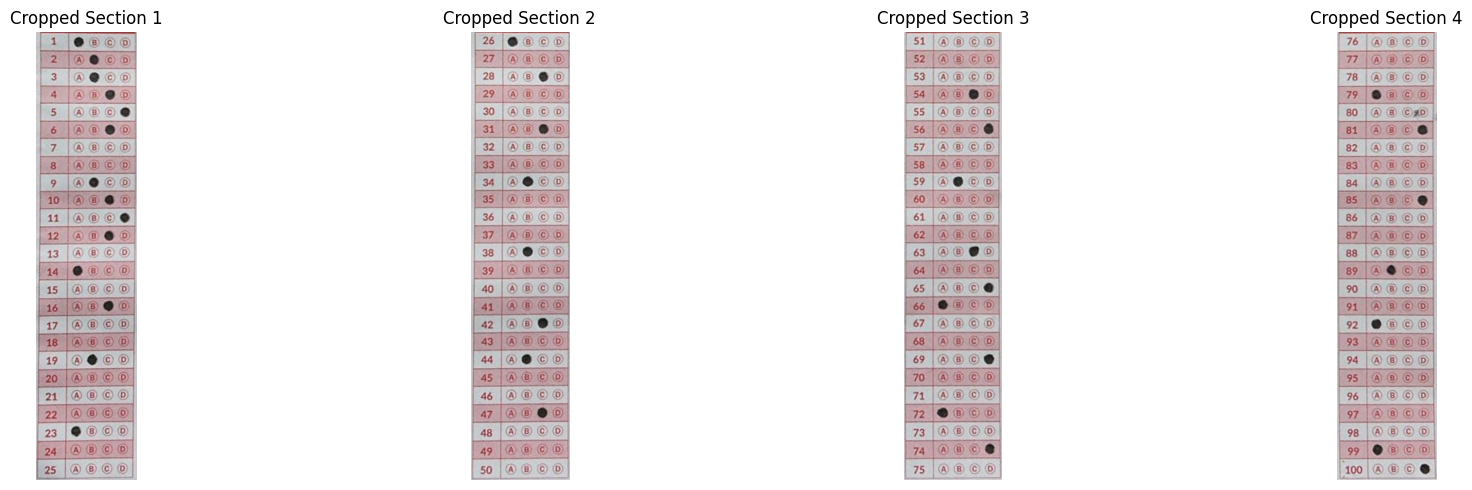

In [29]:
# Load the aligned OMR sheet image
aligned_image = warped  # The output from the previous alignment step

# Convert to grayscale
gray = cv2.cvtColor(aligned_image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Adaptive Thresholding to highlight regions
thresholded = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
)

# Detect contours in the thresholded image
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours to find the answer sheet regions (based on contour area or shape)
answer_sheet_contours = []
for contour in contours:
    area = cv2.contourArea(contour)
    if 50000 < area < 1000000:  # Adjust the range based on actual sizes of answer sheet parts
        answer_sheet_contours.append(contour)

# Sort contours left-to-right based on x-coordinate
def sort_contours(cnts):
    bounding_boxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, bounding_boxes) = zip(*sorted(zip(cnts, bounding_boxes),
        key=lambda b: b[1][0]))  # Sort by the x-coordinate of the bounding box
    return cnts, bounding_boxes

sorted_answer_sheets, bounding_boxes = sort_contours(answer_sheet_contours)

# Store the detected sections in variables
sections = []
for x, y, w, h in bounding_boxes:
    section = aligned_image[y:y+h, x:x+w]
    sections.append(section)

# Function to crop the upper side of each section to remove the title
def crop_title(section, crop_height):
    return section[crop_height:, :]

# Define the height to crop (adjust this value as needed)
crop_height = 23  # Adjust based on the height of the title

# Crop the titles from each section
cropped_sections = [crop_title(section, crop_height) for section in sections]

# Display the cropped sections in sequence from left to right
fig, axes = plt.subplots(1, len(cropped_sections), figsize=(20, 5))
for i, section in enumerate(cropped_sections):
    axes[i].imshow(cv2.cvtColor(section, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'Cropped Section {i+1}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


# Step-by-Step Process for Detecting and Mapping Answers from OMR Sections

## 1. Initialize EasyOCR Reader
- Set up EasyOCR with the English language to detect question numbers.

## 2. Enhance Resolution for Each Section
- Use a resolution enhancement function to upscale each section image for better OCR accuracy.

## 3. Define Question Number Ranges
- Split the questions into predefined ranges for each section (e.g., 1–25, 26–50).

## 4. Detect Question Numbers and Bounding Boxes
- Crop the left region of each section to isolate question numbers.
- Apply OCR to detect question numbers and create bounding boxes for their locations.

## 5. Detect Blackened Pixels for Answers
- Create answer regions adjacent to question number boxes.
- Convert the answer region to grayscale and apply thresholding to detect blackened pixels.
- Find contours representing the blackened bubbles for answers.

## 6. Map Detected Bubbles to Answer Options
- Divide the answer region into four parts corresponding to options A, B, C, and D.
- Map detected blackened pixels to their nearest option based on their position.

## 7. Store and Organize Detected Answers
- Store answers in the format `(question_number, answer)`.
- If no bubble is detected for a question, mark it as "Not Answered."

## 8. Print Detected Answers
- Print the results for each question in the format `question_number) answer`.

## Parameters Used
- **Crop Width**: Width of the region containing question numbers.
- **Answer Box Width**: Width of the region containing answer options.
- **Thresholding**: Parameters for converting the answer region to binary for bubble detection.
- **Contour Filtering**: Minimum size for detected bubbles to qualify as answers.

## Final Output
- Display detected answers in a human-readable format, such as:


In [30]:
# Initialize easyocr reader
reader = easyocr.Reader(['en'])

# Function to enhance resolution
def enhance_resolution(image, scale_factor=2.5):
    enhanced_image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
    return enhanced_image

# Enhance resolution for each section (for initial detection, not the whole section enhancement)
enhanced_sections = [enhance_resolution(section) for section in cropped_sections]

# Define the question number ranges for each section
section_ranges = [(1, 25), (26, 50), (51, 75), (76, 100)]

# Function to detect question numbers using OCR and create bounding boxes
def detect_question_numbers_with_boxes(section, crop_width):
    # Crop the left part of the section to isolate the question numbers
    question_numbers_region = section[:, :crop_width]

    # Apply OCR to detect the question numbers
    result = reader.readtext(question_numbers_region)

    question_numbers = []
    boxes = []

    for (bbox, text, _) in result:
        question_numbers.append(text)
        boxes.append(bbox)

    return question_numbers, boxes, section

# Function to detect blackened pixels within the extended bounding boxes
def detect_blackened_pixels(section, boxes, crop_width, answer_box_width):
    blackened_positions_all = []

    for bbox in boxes:
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = tuple(map(int, top_left))
        bottom_right = tuple(map(int, bottom_right))

        # Create an answer box to the right of the question number box
        answer_box = section[top_left[1]:bottom_right[1], crop_width:crop_width + answer_box_width]

        # Convert the answer box to grayscale and apply thresholding
        gray = cv2.cvtColor(answer_box, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 70, 255, cv2.THRESH_BINARY_INV)

        # Detect contours in the thresholded image
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        blackened_positions = []
        # Store the positions of detected blackened bubbles
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > 10 and h > 10:  # Ensure the detected contour is of reasonable size
                blackened_positions.append((x, y, w, h))

        blackened_positions_all.append((answer_box, blackened_positions))

    return blackened_positions_all

# Function to map detected blackened bubbles to answer options and print results
def map_bubbles_to_answers(section_ranges, blackened_positions_all, answer_box_width):
    answer_options = ['A', 'B', 'C', 'D']
    question_answers = []

    for i, (range_start, range_end) in enumerate(section_ranges):
        current_section_positions = blackened_positions_all[i]

        for j, (answer_box, blackened_positions) in enumerate(current_section_positions):
            question_number = range_start + j
            if blackened_positions:
                for (x, y, w, h) in blackened_positions:
                    # Determine the answer option based on the proximity to one of the 4 parts
                    part_width = answer_box_width // 4
                    if x < part_width:
                        answer = 'A'
                    elif x < 2 * part_width:
                        answer = 'B'
                    elif x < 3 * part_width:
                        answer = 'C'
                    else:
                        answer = 'D'
                    question_answers.append((question_number, answer))
            else:
                question_answers.append((question_number, "Not Answered"))

    return question_answers

# Example usage
crop_width = 115  # Width of the question number region
answer_box_width = 200  # Width of the answer box region

# Process each section and map answers
all_blackened_positions_all = []
for section, (range_start, range_end) in zip(enhanced_sections, section_ranges):
    question_numbers, boxes, section_with_boxes = detect_question_numbers_with_boxes(section, crop_width)
    blackened_positions_all = detect_blackened_pixels(section, boxes, crop_width, answer_box_width)
    all_blackened_positions_all.append(blackened_positions_all)

question_answers = map_bubbles_to_answers(section_ranges, all_blackened_positions_all, answer_box_width)

# Print the detected answers in the desired format
for question_number, answer in question_answers:
    print(f"{question_number}) {answer}")


1) A
2) B
3) B
4) C
5) D
6) C
7) Not Answered
8) Not Answered
9) B
10) C
11) D
12) C
13) Not Answered
14) A
15) Not Answered
16) B
17) Not Answered
18) Not Answered
19) A
20) Not Answered
21) Not Answered
22) Not Answered
23) A
24) Not Answered
25) Not Answered
26) A
27) Not Answered
28) B
29) Not Answered
30) Not Answered
31) B
32) Not Answered
33) Not Answered
34) A
35) Not Answered
36) Not Answered
37) Not Answered
38) A
39) Not Answered
40) Not Answered
41) Not Answered
42) B
43) Not Answered
44) A
45) Not Answered
46) Not Answered
47) B
48) Not Answered
49) Not Answered
50) Not Answered
51) Not Answered
52) Not Answered
53) Not Answered
54) B
55) Not Answered
56) C
57) Not Answered
58) Not Answered
59) A
60) Not Answered
61) Not Answered
62) Not Answered
63) B
64) Not Answered
65) C
66) A
67) Not Answered
68) Not Answered
69) C
70) Not Answered
71) Not Answered
72) A
73) Not Answered
74) C
75) Not Answered
76) Not Answered
77) Not Answered
78) Not Answered
79) A
80) Not Answered
8

In [32]:
#Plot all detected blackened pixel chunks
plt.figure(figsize=(20, len(question_answers) * 5))

for i, (answer_box, blackened_positions) in enumerate(all_blackened_positions_all[0]):
    # Plot the answer box
    plt.subplot(len(all_blackened_positions_all[0]), 2, 2*i+1)
    plt.imshow(cv2.cvtColor(answer_box, cv2.COLOR_BGR2RGB))
    plt.title(f"Answer Box {i+1}")
    plt.axis("off")

    # Highlight the detected blackened pixel chunks
    for (x, y, w, h) in blackened_positions:
        cv2.rectangle(answer_box, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.subplot(len(all_blackened_positions_all[0]), 2, 2*i+2)
    plt.imshow(cv2.cvtColor(answer_box, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected Blackened Pixels {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()